# Download Dataset From Kaggle
[Kaggle Dataset Link](https://www.kaggle.com/datasets/wwymak/architecture-dataset)<br>
Originally from paper: [Architectural Style Classification Using Multinomial Latent Logistic Regression](https://pdfs.semanticscholar.org/0ed0/eb02de7579c714236c480f06faf239f3cd95.pdf)

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

! kaggle datasets download -d wwymak/architecture-dataset

100% 1.43G/1.43G [00:53<00:00, 20.7MB/s]
100% 1.43G/1.43G [00:53<00:00, 28.7MB/s]


In [ ]:
! unzip "architecture-dataset"

# Dataset Setup

In [119]:
import torch
from torchvision import datasets, transforms,  models
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

In [98]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [99]:
fpath = './arcDataset'
IMG_SIZE = 256
transformations = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),\
                                      transforms.ToTensor()]
                                     )

image_dataset = datasets.ImageFolder(fpath, transform=transformations)

Train/Dev/Test Split

In [100]:
# Define the split ratios (70% train, 15% validation, 15% test)
total_count = len(image_dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.15 * total_count)
test_count = total_count - train_count - valid_count

# Split the dataset
train_indices, valid_indices, test_indices = torch.utils.data.random_split(
    range(total_count), [train_count, valid_count, test_count]
)

# Create custom Subset classes with different transforms
train_dataset = Subset(image_dataset, train_indices)
dev_dataset = Subset(image_dataset, valid_indices)
test_dataset = Subset(image_dataset, test_indices)

In [101]:
# Create data loaders
BATCH_SIZE = 32
NUM_WORKER = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER)

In [102]:
class_names = {idx: cls for cls, idx in train_loader.dataset.dataset.class_to_idx.items()}
classes = train_loader.dataset.dataset.classes
print(f'Batch Size: {train_loader.batch_size}')
print(f'Images Count (per batch): {len(train_loader)}')
print(f'Total Images Count (train set): {len(train_loader.dataset)}')
print(f'Total Images Count (dev set): {len(dev_loader.dataset)}')
print(f'Total Images Count (test set): {len(test_loader.dataset)}')
print(f'Total Classes: {len(classes)}')
classes

Batch Size: 32
Images Count (per batch): 105
Total Images Count (train set): 3355
Total Images Count (dev set): 719
Total Images Count (test set): 720
Total Classes: 25


['Achaemenid architecture',
 'American Foursquare architecture',
 'American craftsman style',
 'Ancient Egyptian architecture',
 'Art Deco architecture',
 'Art Nouveau architecture',
 'Baroque architecture',
 'Bauhaus architecture',
 'Beaux-Arts architecture',
 'Byzantine architecture',
 'Chicago school architecture',
 'Colonial architecture',
 'Deconstructivism',
 'Edwardian architecture',
 'Georgian architecture',
 'Gothic architecture',
 'Greek Revival architecture',
 'International style',
 'Novelty architecture',
 'Palladian architecture',
 'Postmodern architecture',
 'Queen Anne architecture',
 'Romanesque architecture',
 'Russian Revival architecture',
 'Tudor Revival architecture']

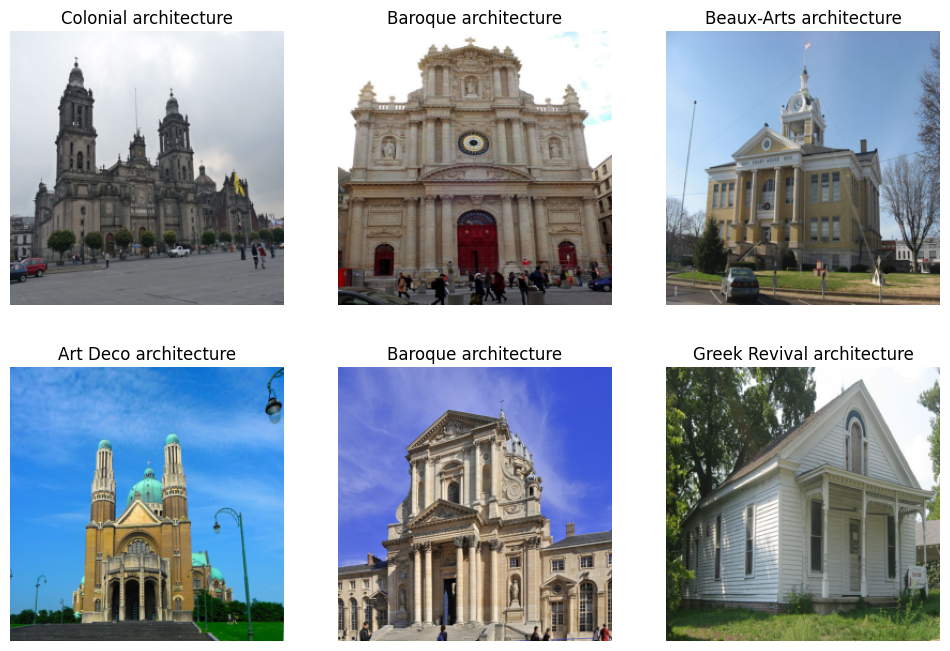

In [103]:
figure = plt.figure(figsize=(12, 8))
num_of_images = 6
images, labels = next(iter(train_loader))

for i in range(1, num_of_images + 1):
    index = int(torch.randint(low=0, high=len(images), size=(1,))[0])
    plt.subplot(2, 3, i)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
    plt.title(f'{classes[labels[index]]}')

Visualize Count Distribution for Train/Dev/Test Images

In [104]:
# Get the class labels (targets) for both train and test datasets
train_labels = [label for _, label in tqdm(train_dataset)]
dev_labels =  [label for _, label in tqdm(dev_dataset)]
test_labels = [label for _, label in tqdm(test_dataset)]

  0%|          | 0/3355 [00:00<?, ?it/s]

  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

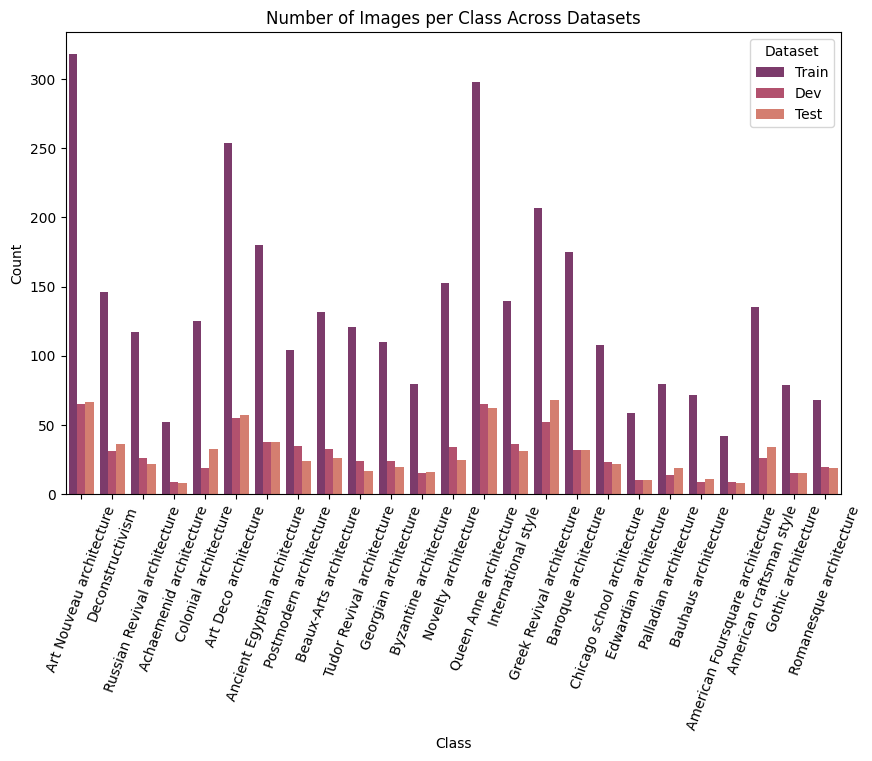

In [105]:
# Count the occurrences of each class label
train_class_counts = dict(Counter(train_labels))
dev_class_counts = dict(Counter(dev_labels))
test_class_counts = dict(Counter(test_labels))

# Prepare the count dataframe for visualization
data = []
for dataset_name, class_counts in [("Train", train_class_counts), ("Dev", dev_class_counts), ("Test", test_class_counts)]:
    for class_label, count in class_counts.items():
        data.append({"Dataset": dataset_name, "Class": classes[class_label], "Count": count})

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Count", hue="Dataset", data=df, palette='flare_r')
plt.title("Number of Images per Class Across Datasets")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.legend(title="Dataset")
plt.show()

# Train Model

In [114]:
model = models.resnet18(weights=True)
summary(model, input_size = (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [116]:
# remove last fully-connected layer
feature_extractor = nn.Sequential(*list(model.children())[:-1])
# Check if it works
x = torch.randn([1, 3, IMG_SIZE, IMG_SIZE])
output = feature_extractor(x)
print("Output shape:", output.shape)  # Should be (1, 512, 1, 1)

Output shape: torch.Size([1, 512, 1, 1])


In [118]:
summary(feature_extractor, input_size = (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [121]:
# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the custom classifier
num_classes = len(class_names)
classifier = CustomClassifier(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)